<a href="https://colab.research.google.com/github/OmkarSarkar204/NSAC/blob/main/NSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5959 - loss: 0.8238 - val_accuracy: 0.0368 - val_loss: 0.8872
Epoch 2/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7915 - loss: 0.4561 - val_accuracy: 0.9667 - val_loss: 0.5992
Epoch 3/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8887 - loss: 0.3161 - val_accuracy: 0.9912 - val_loss: 0.1723
Epoch 4/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9198 - loss: 0.2496 - val_accuracy: 0.9895 - val_loss: 0.1995
Epoch 5/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9522 - loss: 0.1797 - val_accuracy: 0.9807 - val_loss: 0.3592
Epoch 6/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9559 - loss: 0.1544 - val_accuracy: 0.9930 - val_loss: 0.2303
Epoch 7/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9713 - loss: 0.1010 - val_accuracy: 0.9912 - val_loss: 0.0726
Epoch 8/25
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9730 - loss: 0.0990 - val_ac

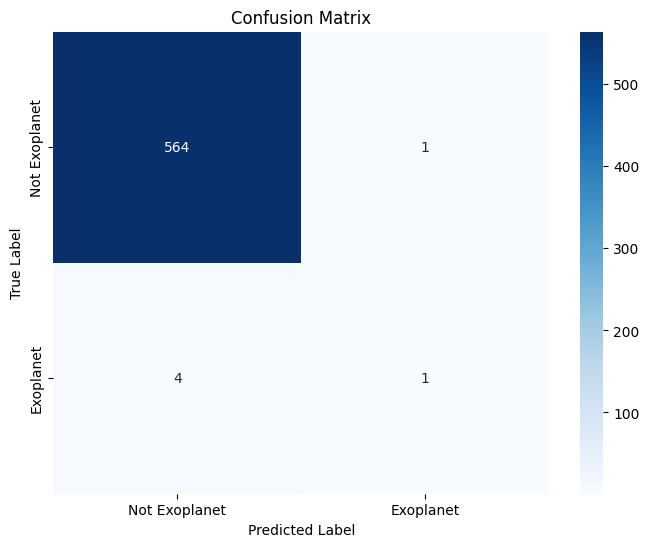

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras

df_train = pd.read_csv('exoTrain.csv')
df_test = pd.read_csv('exoTest.csv')
df = pd.concat([df_train, df_test], ignore_index=True)

df.replace('-', np.nan, inplace=True)
df.fillna(0, inplace=True)

X = df.drop('LABEL', axis=1)
y = df['LABEL'].replace({1: 0, 2: 1})
X = X.astype(np.float64)

X_train = X.iloc[:len(df_train)]
y_train = y.iloc[:len(df_train)]
X_test = X.iloc[len(df_train):]
y_test = y.iloc[len(df_train):]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

X_train_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_reshaped.shape[1], 1)),
    keras.layers.Conv1D(32, 5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(64, 5, activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_reshaped,
    y_train_resampled,
    epochs=25,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test),
    verbose=1
)

y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, target_names=['Not Exoplanet', 'Exoplanet']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Exoplanet', 'Exoplanet'],
            yticklabels=['Not Exoplanet', 'Exoplanet'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


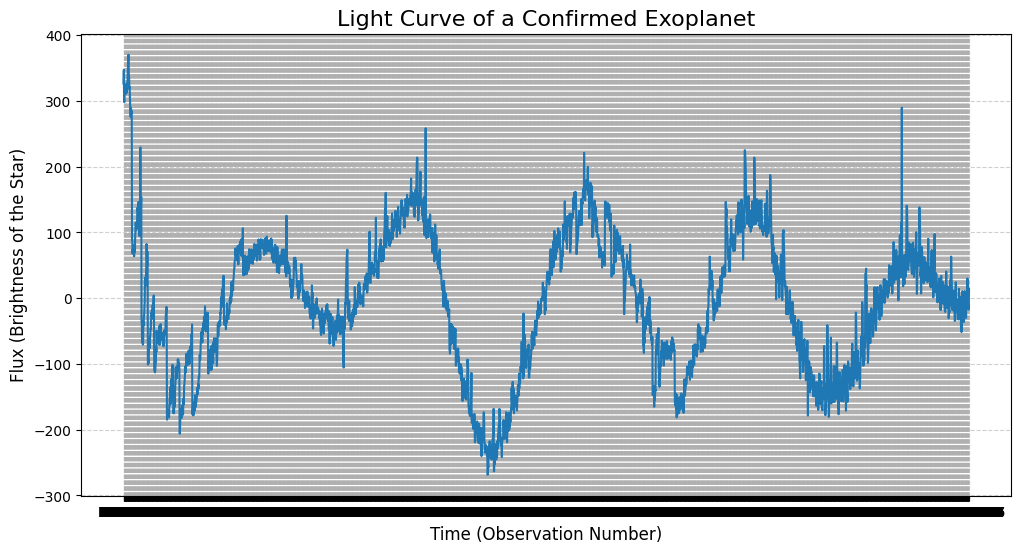

In [11]:
import matplotlib.pyplot as plt

exoplanets = df_train[df_train['LABEL'] == 2]
exoplanet_row = exoplanets.iloc[3]
flux_values = exoplanet_row.drop('LABEL')

plt.figure(figsize=(12, 6))
plt.plot(flux_values)
plt.title('Light Curve of a Confirmed Exoplanet', fontsize=16)
plt.xlabel('Time (Observation Number)', fontsize=12)
plt.ylabel('Flux (Brightness of the Star)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

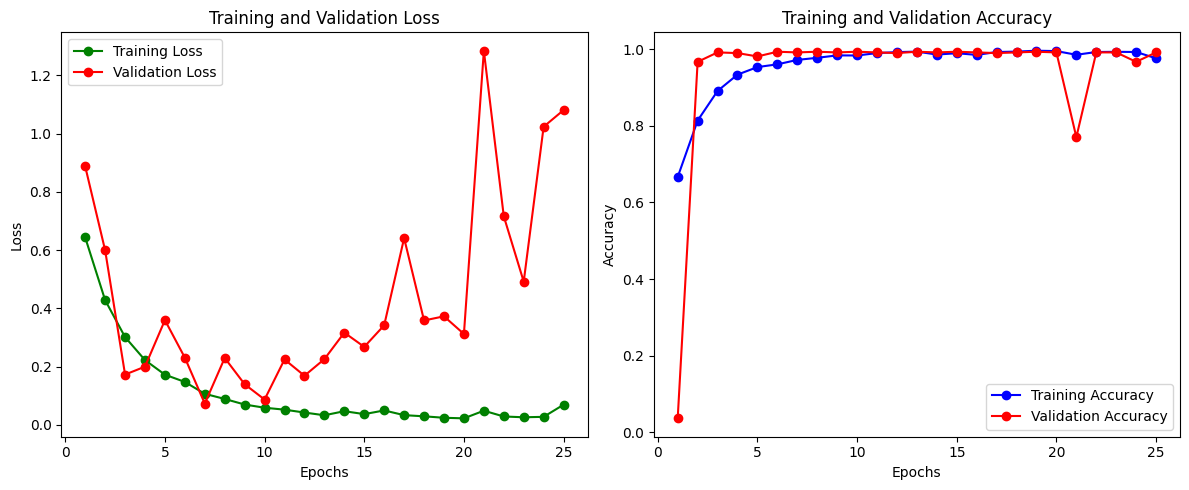

In [12]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'go-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()